In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings('ignore')

In [4]:
#load processed csv
df_los_p=pd.read_csv('df_los_p_o.csv')
df_los_p.head()

,EpisodeReference,HospitalNumber,From_WardId,TransferType,Start_Date,End_Date,Ward,los_days,start_month,Ward Code,Ward Name,Ward Service Type,Ward Location,Age,Gender
0,103469,1798.0,0,0.0,2017-01-12 02:00:00,2017-01-17 17:00:00,I_RXTD2_SAFFRON,5,1,I_RXTD2_SAFFRON,Zinnia - Saffron,Adult Acute,The Zinnia Centre,44,M
1,103517,149.0,0,0.0,2017-01-18 16:39:00,2017-04-26 10:30:00,I_RXTD2_SAFFRON,97,1,I_RXTD2_SAFFRON,Zinnia - Saffron,Adult Acute,The Zinnia Centre,45,M
2,104748,149.0,0,0.0,2017-07-18 16:35:00,2017-07-25 11:00:00,I_RXTD2_SAFFRON,6,7,I_RXTD2_SAFFRON,Zinnia - Saffron,Adult Acute,The Zinnia Centre,45,M
3,103528,1955.0,0,0.0,2017-01-20 05:57:00,2017-01-27 21:22:00,I_RXTD2_SAFFRON,7,1,I_RXTD2_SAFFRON,Zinnia - Saffron,Adult Acute,The Zinnia Centre,52,M
4,103534,2288.0,0,0.0,2017-01-20 21:42:00,2017-02-19 18:54:00,I_RXTD2_SAFFRON,29,1,I_RXTD2_SAFFRON,Zinnia - Saffron,Adult Acute,The Zinnia Centre,32,M


In [5]:
df_los_p.columns

Index(['EpisodeReference', 'HospitalNumber', 'From_WardId', 'TransferType',
       'Start_Date', 'End_Date', 'Ward', 'los_days', 'start_month',
       'Ward Code', 'Ward Name', 'Ward Service Type', 'Ward Location', 'Age',
       'Gender'],
      dtype='object')

In [6]:
#Form the set of attributes
df_los_f=df_los_p.drop(['HospitalNumber','Ward','Ward Code','Start_Date','End_Date','EpisodeReference'],axis=1)           


In [7]:
def plot_Y_against_feature(df,y_los):
    nrows=int(len(df.columns)/2)
    fig, axes = plt.subplots(nrows, ncols=2, figsize=(30,50))
    fig.suptitle='Scatterplots across different inputs'
    columns=df.columns
    n=0
    for i, column in enumerate(columns):
        if i%2==0:
            sns.scatterplot(x=df[column], y=y_los, ax=axes[n][0])
        else:
            sns.scatterplot(x=df[column], y=y_los, ax=axes[n][1])
            n+=1

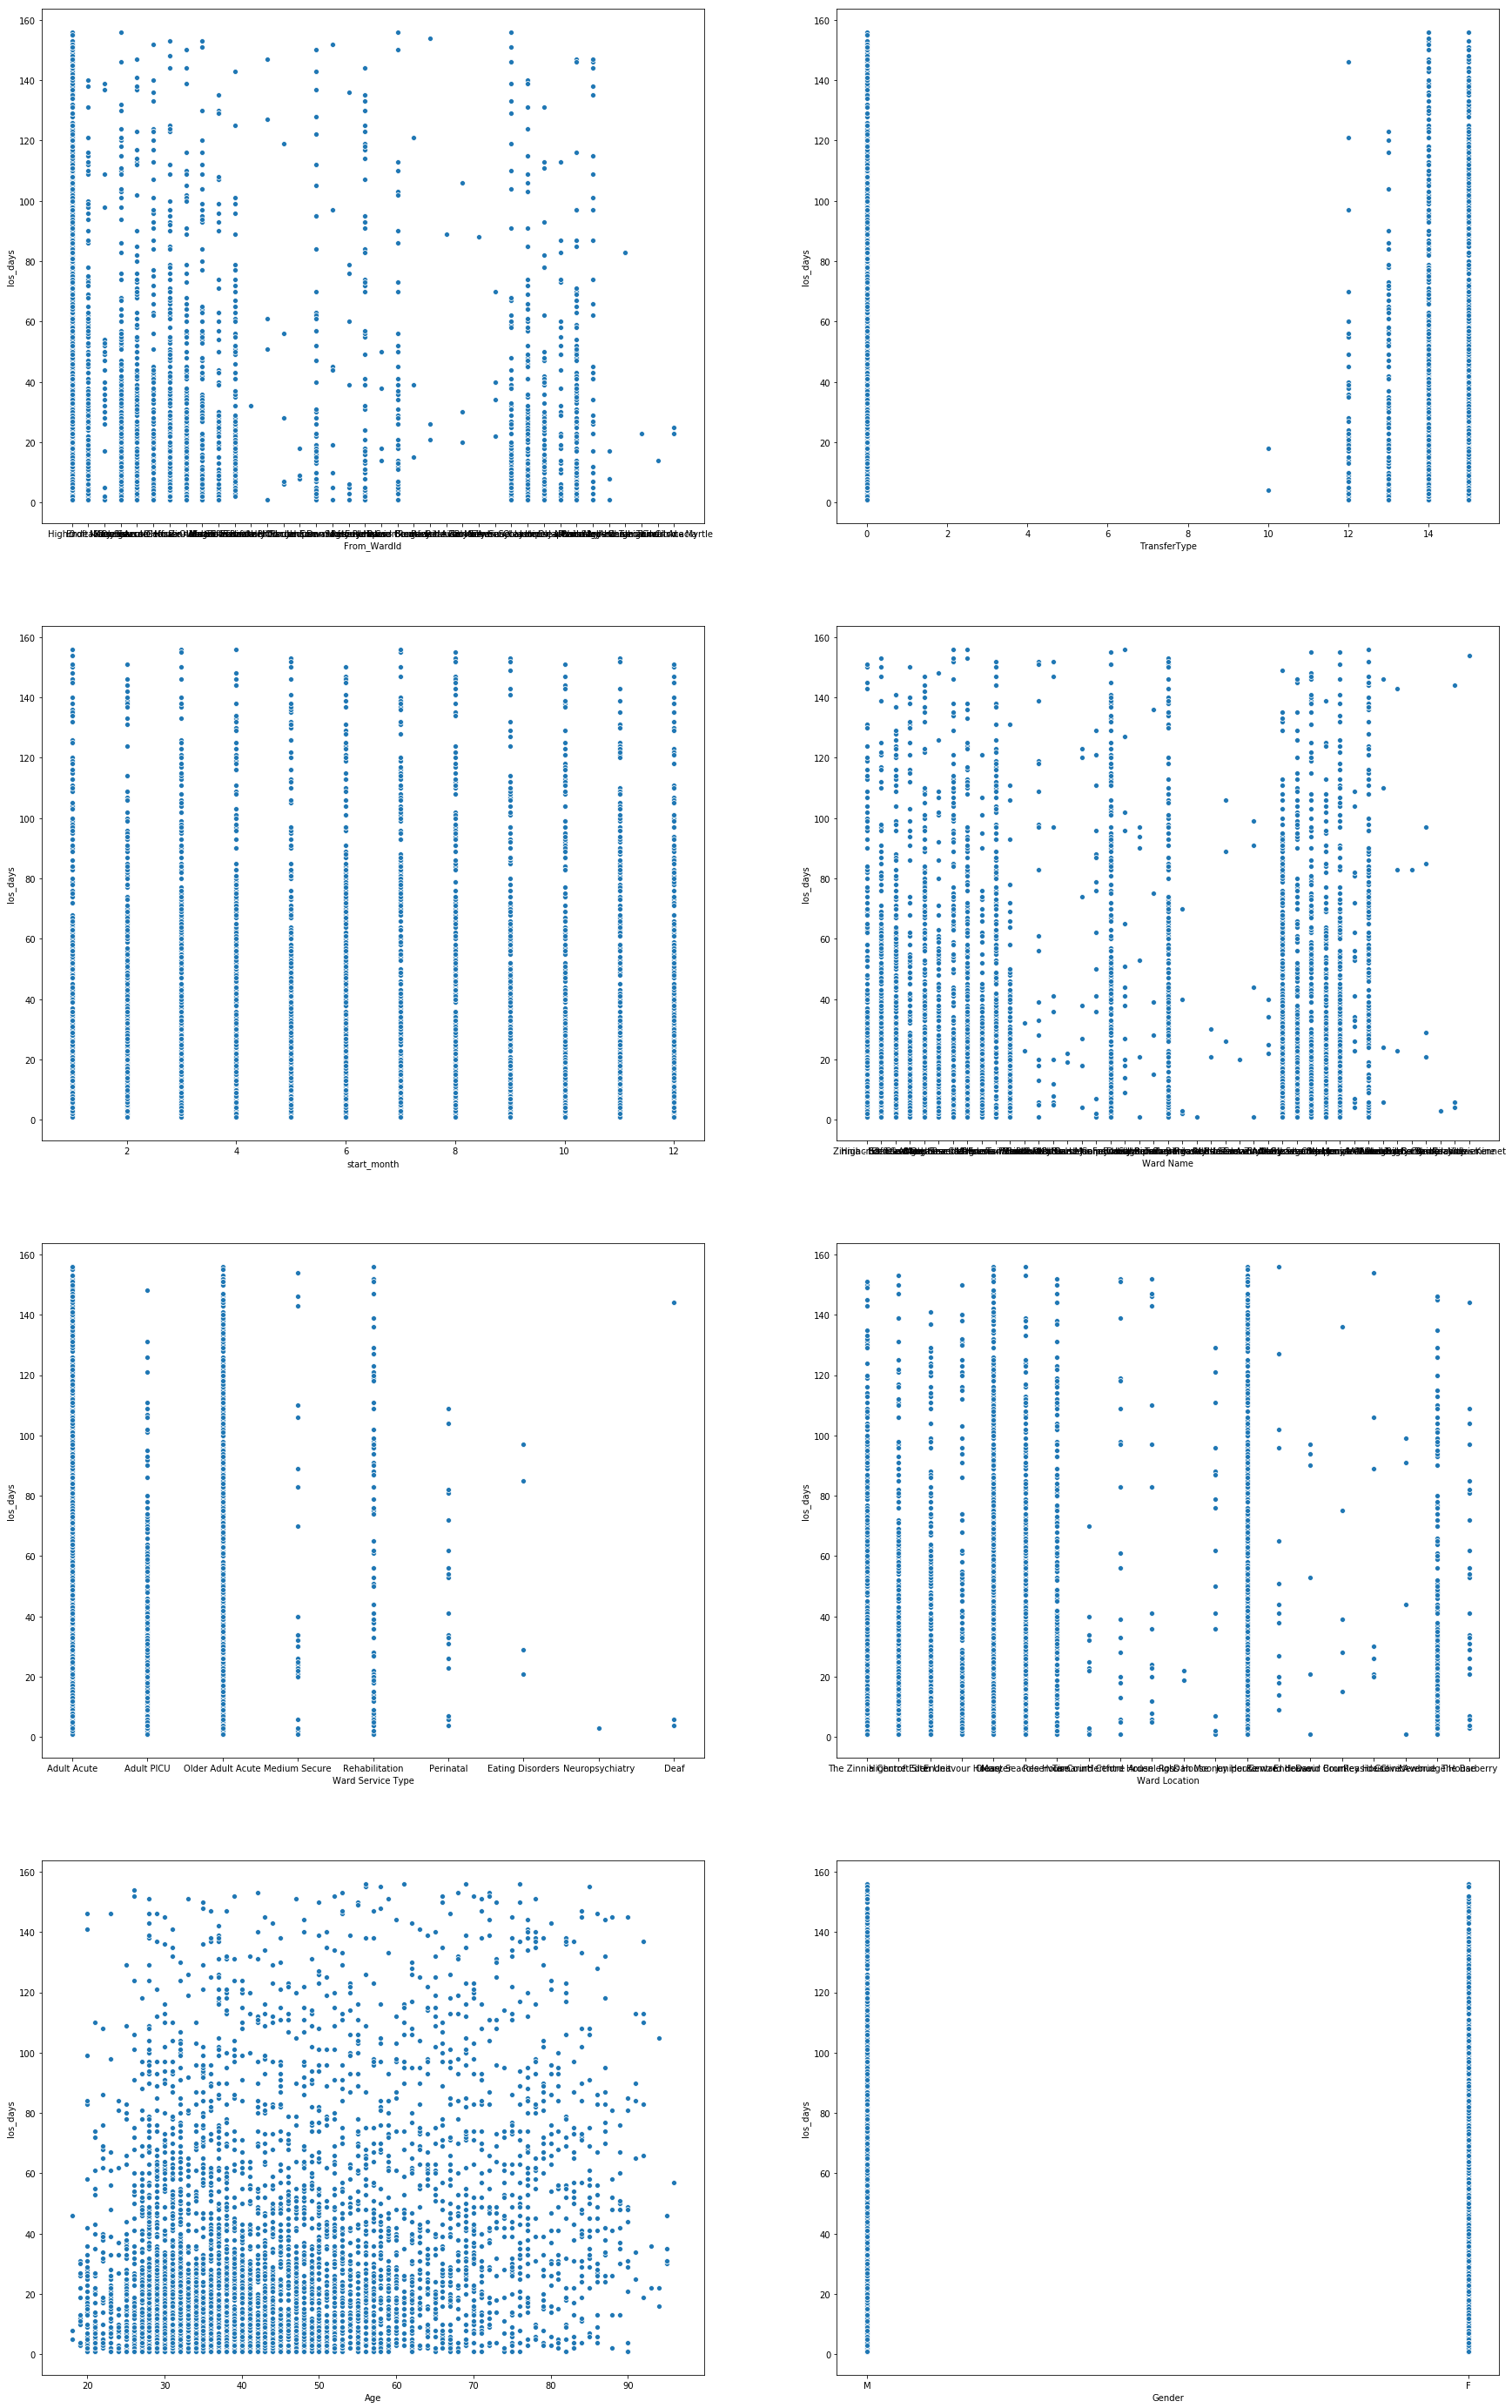

In [8]:
plot_Y_against_feature(df_los_f.drop(['los_days'],axis=1),df_los_f.los_days)

In [9]:
#Encode the categorical values into numerical values
def encoding_manual(df_o,cols):
    df=df_o.copy()
    encoder={}
    
    for i in cols:
        label={}
        for k,v in enumerate(df[i].unique(),start=1):
            label[v]=k
        encoder[i]=label
        
        df[i].replace(label,inplace=True)

    return encoder,df


In [10]:
encoder,df_los_f=encoding_manual(df_los_f,['Gender','Ward Service Type','Ward Location'])

In [11]:
ward_name=set(df_los_f['From_WardId']).union(set(df_los_f['Ward Name']))

In [12]:
#encode ward name
label={}
for k,v in enumerate(ward_name,start=1):
    if v=='0' or 0:
        label[0]=int(0)
    else:
        label[v]=int(k)
encoder['Ward']=label
df_los_f['Ward Name'].replace(label,inplace=True)
df_los_f['From_WardId'].replace(label,inplace=True)

In [13]:
df_los_f.shape

(5087, 9)

In [14]:
df_los_f.sample(5)

,From_WardId,TransferType,los_days,start_month,Ward Name,Ward Service Type,Ward Location,Age,Gender
2802,17,14.0,10,8,34,3,13,70,2
4976,0,0.0,17,12,39,1,5,52,2
4883,0,0.0,26,10,38,3,13,75,1
4184,0,0.0,22,7,18,1,3,56,1
4028,12,15.0,49,11,12,1,2,50,1


In [15]:
def Standard_Scaler(df,col_names):
    from sklearn.preprocessing import StandardScaler
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

In [16]:
#Plot heatmap of correlation among features and target variable
def plot_heatmap(df,threshold):
    sns.set(rc={'figure.figsize':(18,18)})
    corr = df.corr()
    ax = sns.heatmap(
        corr, 
        annot=True,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    
    #Correlation with los
    los_cor = abs(corr["los_days"])
    #Selecting correlated features according to threshold
    relevant_features = los_cor[los_cor>threshold]
    return relevant_features

In [17]:
#define X and Y attributes
X_los=df_los_f.drop(['los_days'],axis=1)
y_los=df_los_f['los_days']

In [18]:
X_los.sample(5)

,From_WardId,TransferType,start_month,Ward Name,Ward Service Type,Ward Location,Age,Gender
703,27,15.0,5,27,1,1,32,1
2258,39,14.0,4,11,5,16,58,2
1817,0,0.0,9,19,1,1,46,2
4237,24,15.0,5,24,2,6,42,1
1318,3,13.0,10,3,1,5,30,1


In [19]:
#Use PCA to reduce multivariate features to few dimensions for data visualisation
def transform_PCA(data,n):
    from sklearn.decomposition import PCA
    pca=PCA(n_components=n)
    transformed=pd.DataFrame(pca.fit_transform(data))
    return transformed

In [20]:
transformed=transform_PCA(X_los,2)

In [21]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d(x,y,z,angle=45):
    fig=plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z,c=y_los,marker='^')

    ax.set_xlabel('transformed[0]')
    ax.set_ylabel('transformed[1]')
    ax.set_zlabel('y_los')

    ax.view_init(30, angle)

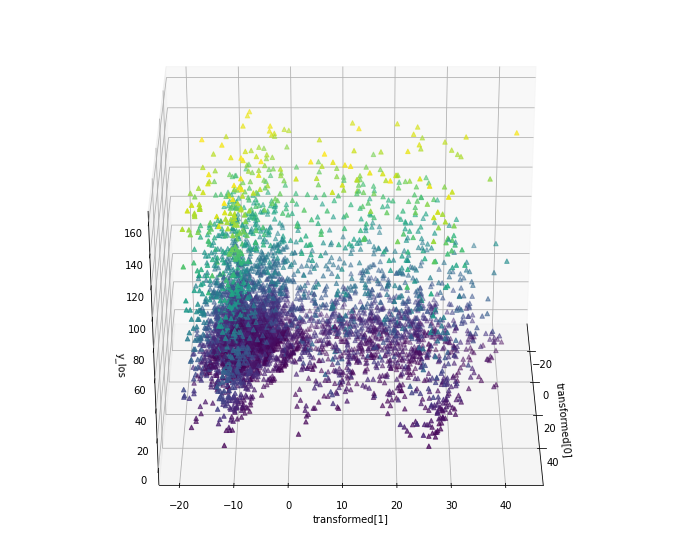

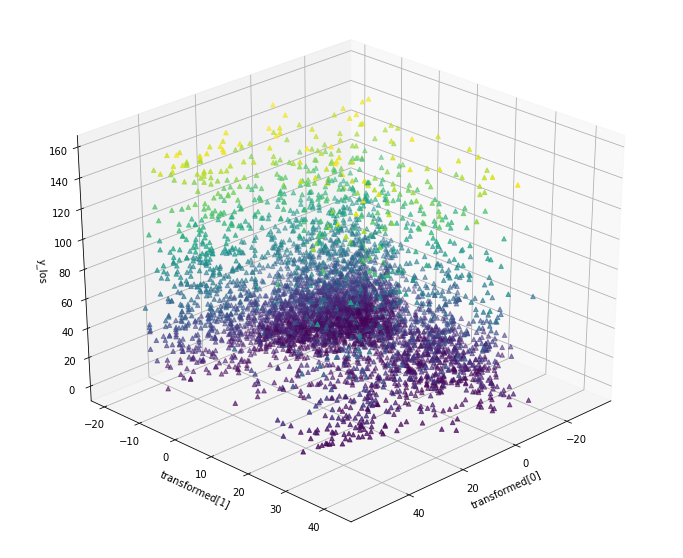

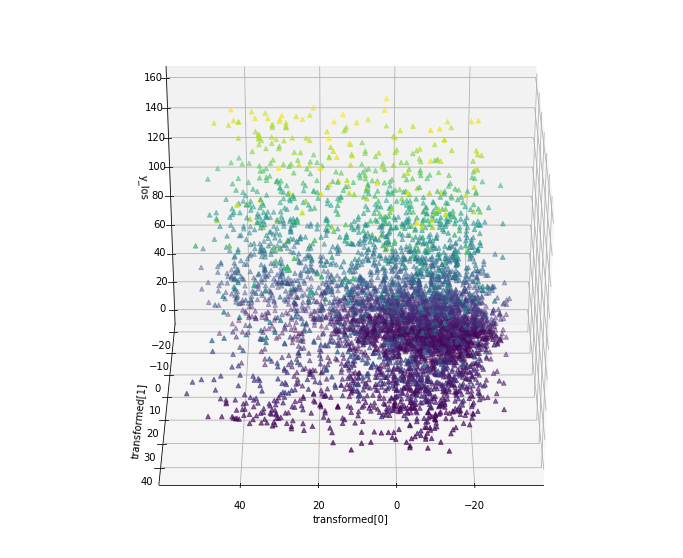

In [22]:
plot_3d(transformed[0],transformed[1],y_los,0)
plot_3d(transformed[0],transformed[1],y_los)
plot_3d(transformed[0],transformed[1],y_los,90)

In [23]:
def X_Y_plot(x,col,y):
    fig=plt.figure()
    ax=plt.axes()
    ax.scatter(x[col],y)
    plt.show()

In [24]:
df_los_f.columns

Index(['From_WardId', 'TransferType', 'los_days', 'start_month', 'Ward Name',
       'Ward Service Type', 'Ward Location', 'Age', 'Gender'],
      dtype='object')

In [25]:
df_los_f['From_WardId']=pd.to_numeric(df_los_f['From_WardId'])
       

In [26]:
df_los_f.From_WardId.dtype

dtype('int64')

In [120]:
#plot length of stay distribution
def plot_boxplot(df,col):
    df_n=pd.DataFrame()
    for i in df[col].unique():
    #     print(df_los_f[df_los_f.admission_month==i].los_days.values)
        if df_n.shape==(0,0):
            df_n[i]=df[df[col]==i].los_days.values
        else:
            df_x=pd.DataFrame()
            df_x[i]=df[df[col]==i].los_days.values
            df_n=pd.concat([df_n,df_x],axis=1)
    df_n.sort_index(axis=1,inplace=True)
    df_n.boxplot(figsize=(10,5))
    return df_n

In [28]:
#remove outlier based on IQR
from scipy.stats import iqr
def get_outliers(data,col):
    d=data[col].dropna()
    q1=d.quantile(0.25)
    q3=d.quantile(0.75)
    IQR=q3-q1
    d=d[((d<(q1-IQR))| (d>(q3+IQR)))]
    return d

def remove_outliers(data,col,df):
    
    df=df.copy()
    
    for i in data:
        d=get_outliers(data,i)
        df.drop(df[(df[col]==i)&(df.los_days.isin(d))].index,axis=0,inplace=True)
    
    return df

In [29]:
for i in ('start_month','Age','Ward Name','From_WardId','TransferType','Ward Location','Ward Service Type'):
    d=get_outliers(df_los_f,i)
    print(f'no. of outliers in {i}: {len(d)}')

no. of outliers in start_month: 0
no. of outliers in Age: 208
no. of outliers in Ward Name: 0
no. of outliers in From_WardId: 682
no. of outliers in TransferType: 0
no. of outliers in Ward Location: 850
no. of outliers in Ward Service Type: 140


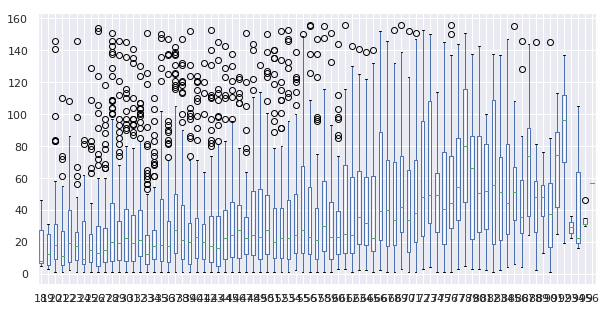

In [121]:
df_age=plot_boxplot(df_los_f,'Age')

In [31]:
df_los_new=remove_outliers(df_age,'Age',df_los_f)

,1,2,3,4,5,6,7,8,9
0,5,35.0,28.0,32.0,61.0,6.0,29.0,3.0,4.0
1,97,52.0,18.0,2.0,6.0,53.0,85.0,3.0,6.0
2,6,25.0,39.0,3.0,22.0,72.0,21.0,NaN,144.0
3,7,11.0,55.0,1.0,27.0,31.0,97.0,NaN,NaN
4,29,26.0,63.0,21.0,36.0,81.0,NaN,NaN,NaN
5,47,21.0,23.0,26.0,109.0,23.0,NaN,NaN,NaN
6,69,26.0,19.0,89.0,38.0,41.0,NaN,NaN,NaN
7,30,28.0,70.0,20.0,62.0,7.0,NaN,NaN,NaN
8,22,5.0,60.0,34.0,21.0,104.0,NaN,NaN,NaN
9,4,18.0,2.0,34.0,7.0,62.0,NaN,NaN,NaN


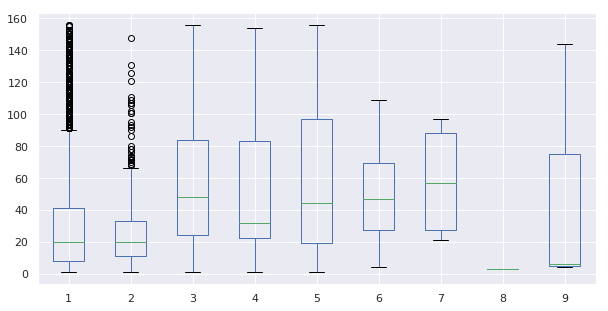

In [122]:
plot_boxplot(df_los_f,'Ward Service Type')

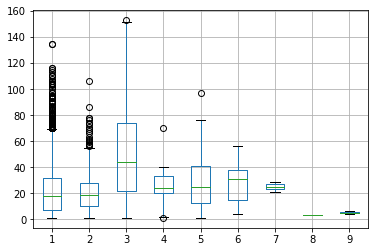

In [32]:
df_wst=plot_boxplot(df_los_new,'Ward Service Type')

In [33]:
df_los_new=remove_outliers(df_wst,'Ward Service Type',df_los_new)

In [34]:
import jenkspy
def goodness_of_variance_fit(array, n):
    # get the break points
    classes=jenkspy.jenks_breaks(array,nb_class=n)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)
        
    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1


In [35]:
classes=jenkspy.jenks_breaks(df_los_new['Age'],nb_class=7)
df_los_new['Age'] = np.array([classify(i, classes) for i in df_los_new['Age']])

,0,1,2,3,4,5,7,9,10,11,...,32,34,35,37,38,39,40,41,42,43
0,5,14.0,13.0,11.0,26.0,23.0,36.0,45.0,6.0,39.0,...,23.0,70.0,3.0,39.0,5.0,15.0,30.0,21.0,3.0,51.0
1,6,37.0,22.0,25.0,27.0,25.0,22.0,10.0,7.0,15.0,...,NaN,4.0,25.0,14.0,18.0,3.0,38.0,26.0,1.0,1.0
2,7,4.0,16.0,8.0,22.0,NaN,33.0,5.0,28.0,NaN,...,NaN,1.0,9.0,4.0,23.0,23.0,30.0,NaN,1.0,NaN
3,29,4.0,34.0,28.0,10.0,NaN,33.0,1.0,NaN,NaN,...,NaN,34.0,33.0,3.0,19.0,10.0,40.0,NaN,5.0,NaN
4,15,25.0,3.0,1.0,25.0,NaN,27.0,44.0,NaN,NaN,...,NaN,12.0,6.0,31.0,19.0,3.0,53.0,NaN,1.0,NaN
5,23,12.0,11.0,5.0,27.0,NaN,18.0,19.0,NaN,NaN,...,NaN,1.0,22.0,4.0,40.0,5.0,32.0,NaN,6.0,NaN
6,42,26.0,14.0,20.0,2.0,NaN,22.0,NaN,NaN,NaN,...,NaN,14.0,27.0,1.0,47.0,2.0,34.0,NaN,NaN,NaN
7,11,3.0,13.0,4.0,1.0,NaN,17.0,NaN,NaN,NaN,...,NaN,11.0,31.0,4.0,5.0,18.0,5.0,NaN,NaN,NaN
8,14,3.0,4.0,10.0,17.0,NaN,26.0,NaN,NaN,NaN,...,NaN,36.0,12.0,1.0,4.0,1.0,26.0,NaN,NaN,NaN
9,10,11.0,26.0,4.0,3.0,NaN,19.0,NaN,NaN,NaN,...,NaN,31.0,13.0,41.0,3.0,14.0,44.0,NaN,NaN,NaN


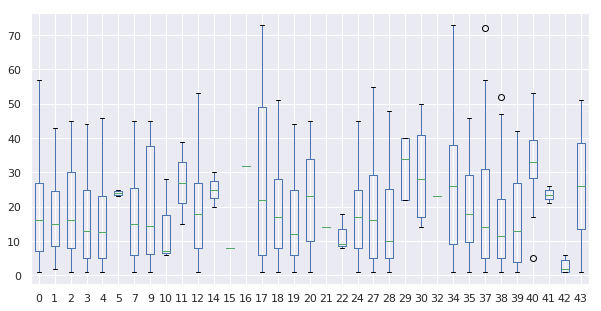

In [123]:
plot_boxplot(df_los_new,'From_WardId')

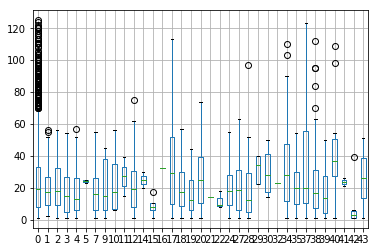

In [36]:
df_fromward=plot_boxplot(df_los_new,'From_WardId')

In [37]:
df_los_new=remove_outliers(df_fromward,'From_WardId',df_los_new)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,5.0,47.0,4.0,2.0,137,22.0,28.0,32.0,61.0,6.0,22.0,36.0,18.0,38.0,21.0,39.0,21.0,91.0,52.0,6.0
1,97.0,69.0,5.0,131.0,35,52.0,39.0,2.0,109.0,12.0,19.0,62.0,23.0,51.0,53.0,75.0,26.0,99.0,9.0,53.0
2,6.0,30.0,1.0,3.0,10,11.0,55.0,3.0,98.0,6.0,NaN,7.0,19.0,14.0,1.0,136.0,89.0,1.0,10.0,72.0
3,7.0,22.0,14.0,8.0,20,9.0,63.0,1.0,139.0,24.0,NaN,50.0,70.0,102.0,97.0,28.0,20.0,44.0,80.0,31.0
4,29.0,13.0,48.0,19.0,110,54.0,98.0,34.0,119.0,97.0,NaN,121.0,60.0,156.0,94.0,15.0,30.0,NaN,22.0,81.0
5,65.0,1.0,7.0,45.0,97,26.0,21.0,34.0,1.0,146.0,NaN,88.0,2.0,127.0,90.0,NaN,106.0,NaN,48.0,23.0
6,15.0,21.0,5.0,28.0,3,28.0,97.0,70.0,152.0,83.0,NaN,96.0,40.0,96.0,NaN,NaN,154.0,NaN,26.0,41.0
7,23.0,43.0,55.0,121.0,25,16.0,29.0,40.0,118.0,83.0,NaN,129.0,60.0,9.0,NaN,NaN,NaN,NaN,17.0,7.0
8,42.0,42.0,7.0,7.0,26,30.0,4.0,23.0,28.0,110.0,NaN,36.0,83.0,20.0,NaN,NaN,NaN,NaN,7.0,104.0
9,53.0,22.0,23.0,38.0,21,63.0,3.0,40.0,20.0,23.0,NaN,87.0,3.0,27.0,NaN,NaN,NaN,NaN,46.0,62.0


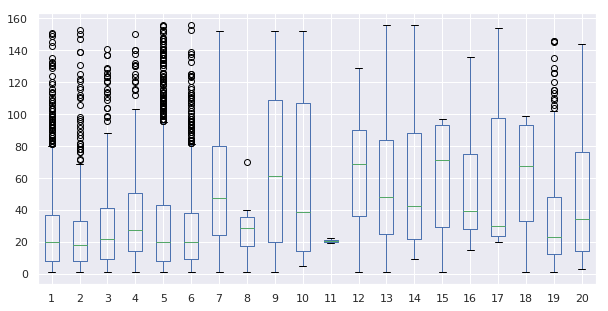

In [124]:
plot_boxplot(df_los_f,'Ward Location')

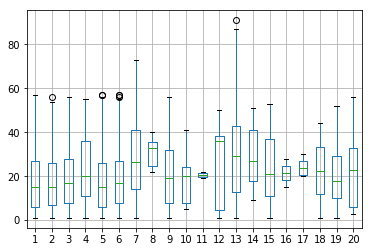

In [38]:
df_wl=plot_boxplot(df_los_new,'Ward Location')

In [39]:
df_los_new=remove_outliers(df_wl,'Ward Location',df_los_new)

In [40]:
df_los_new.shape

(3857, 9)

In [41]:
df_los_f.shape

(5087, 9)

In [42]:
df_los_new.columns

Index(['From_WardId', 'TransferType', 'los_days', 'start_month', 'Ward Name',
       'Ward Service Type', 'Ward Location', 'Age', 'Gender'],
      dtype='object')

In [43]:
#select features based on mutual information

X_all=df_los_new.drop('los_days',axis=1)
y_all=df_los_new['los_days']

from sklearn.feature_selection import mutual_info_regression
mi=mutual_info_regression(X_all,y_all)

mi/=np.max(mi)

print(mi)

[0.09831337 0.06011735 0.049757   1.         0.60341386 0.92344057
 0.37933095 0.        ]


In [44]:
df_los_new.columns

Index(['From_WardId', 'TransferType', 'los_days', 'start_month', 'Ward Name',
       'Ward Service Type', 'Ward Location', 'Age', 'Gender'],
      dtype='object')

In [45]:
df_los_new.columns = [col.replace(' ', '_') for col in df_los_new.columns]

In [46]:

X_mi=df_los_new.drop(['From_WardId','TransferType','Gender'],axis=1)
df_los_mi=X_mi
df_los_mi['los_days']=y_all

In [47]:
#save classification and encoding 
c_e={}
c_e['label']=encoder
c_e['age']=classes

c_e
#pickle
with open('label.pickle','wb') as f:
    pickle.dump(c_e,f)

In [48]:
#Apply Cross Validation

In [49]:
import import_ipynb
from Build_Model import *


importing Jupyter notebook from Build_Model.ipynb


In [50]:
#Use features with high correlation

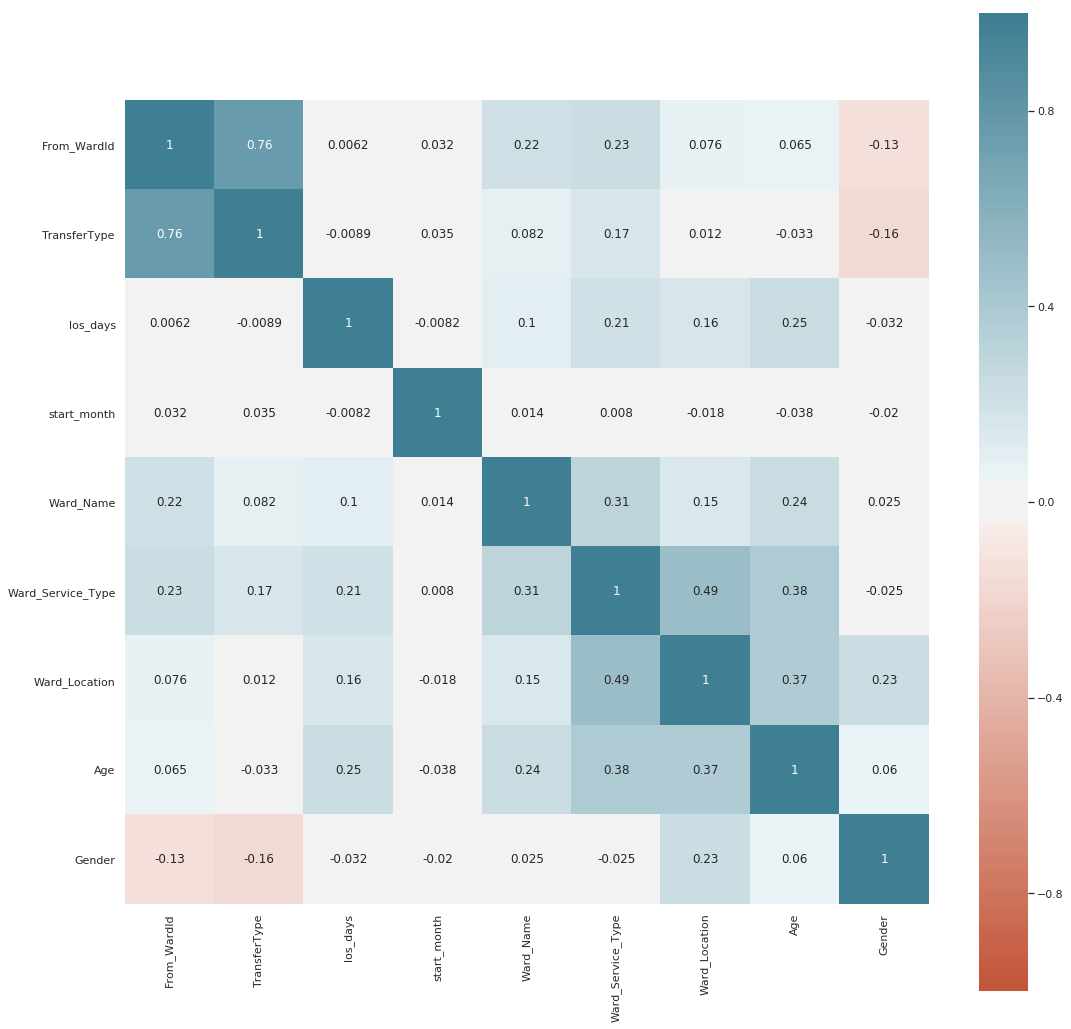

In [51]:
corr_features=plot_heatmap(df_los_new,0.09)

In [52]:
df_los_new_corr=df_los_new[corr_features.index]

In [54]:
X_train_corr,X_test_corr,y_train_corr,y_test_corr=data_split(df_los_new_corr)

In [55]:
model_result_corr_msr,time_corr_msr=run_cv(X_train_corr,y_train_corr,'neg_mean_squared_error',(2,3,4))

Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
160.91520099357516
build_lr- processing time: 00m 0s 135560ms
build_lr- processing time: 00m 0s 082302ms
build_lr- processing time: 00m 0s 106632ms
build_lr- processing time: 00m 0s 168637ms
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
160.50404400084983
build_rf- processing time: 00m 59s 653458ms
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impur

[23:56:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:56:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:56:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:56:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:57:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[23:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [56]:
model_result_corr_r2,time_corr_r2=run_cv(X_train_corr,y_train_corr,'r2',(2,3,4))

Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
-0.0750935627990764
build_lr- processing time: 00m 0s 115710ms
build_lr- processing time: 00m 0s 089002ms
build_lr- processing time: 00m 0s 120086ms
build_lr- processing time: 00m 0s 159089ms
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
-0.07743060513779125
build_rf- processing time: 00m 59s 977323ms
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_im

[00:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:00:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:00:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:01:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:01:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:01:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [57]:
#Use all attributes

In [58]:
X_train_all,X_test_all,y_train_all,y_test_all=data_split(df_los_new)

In [59]:
model_result_all_msr,time_all_msr=run_cv(X_train_all,y_train_all,'neg_mean_squared_error',(2,3,4))

Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
160.68329705408655
build_lr- processing time: 00m 0s 150670ms
build_lr- processing time: 00m 0s 132802ms
build_lr- processing time: 00m 0s 281065ms
build_lr- processing time: 00m 1s 167657ms
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
156.6840559392147
build_rf- processing time: 01m 74s 295179ms
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impuri

[00:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:06:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:07:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:07:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:07:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:07:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [60]:
model_result_all_r2,time_all_r2=run_cv(X_train_all,y_train_all,'r2',(2,3,4))

Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
-0.07618735423088141
build_lr- processing time: 00m 0s 157038ms
build_lr- processing time: 00m 0s 135924ms
build_lr- processing time: 00m 0s 283399ms
build_lr- processing time: 00m 1s 221193ms
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
-0.09894891465409071
build_rf- processing time: 01m 78s 355744ms
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_im

[00:13:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:13:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:13:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:14:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [61]:
model_result_all_msr

{'lr': (Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  160.68329705408655),
 'pr': (Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  160.03442963054914),
 'rf': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
             oob_score=False, random_state=None, verbose=0, warm_start=False),
  156.6840559392147),
 'gbr': (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impur

In [62]:
#Based on mutual information

In [63]:
X_train_mi,X_test_mi,y_train_mi,y_test_mi=data_split(df_los_mi)

In [64]:
model_result_mi_msr,time_mi_msr=run_cv(X_train_mi,y_train_mi,'neg_mean_squared_error',(2,3,4))

Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
161.08993869788705
build_lr- processing time: 00m 0s 138258ms
build_lr- processing time: 00m 0s 103553ms
build_lr- processing time: 00m 0s 135860ms
build_lr- processing time: 00m 0s 228699ms
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
160.13018974103588
build_rf- processing time: 01m 66s 690540ms
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impu

[00:18:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:18:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:18:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:19:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:19:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:19:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:19:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [65]:
model_result_mi_r2,time_mi_r2=run_cv(X_train_mi,y_train_mi,'r2',(2,3,4))

Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
-0.07403487675424396
build_lr- processing time: 00m 0s 127407ms
build_lr- processing time: 00m 0s 096423ms
build_lr- processing time: 00m 0s 140851ms
build_lr- processing time: 00m 0s 224665ms
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
-0.07960913458956276
build_rf- processing time: 01m 62s 993256ms
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_i

[00:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:23:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:23:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:24:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:24:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[00:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [127]:
results_mse_details={'Correlation(>0.09)':model_result_corr_msr,
                 'mutual information(>0.2)':model_result_mi_msr,
                 'All':model_result_all_msr}

In [128]:
results_mse_time={'Correlation(>0.09)':time_corr_msr,
                 'mutual information(>0.2)':time_mi_msr,
                 'All':time_all_msr}

In [136]:
results_r2_time={'Correlation(>0.09)':time_corr_r2,
                 'mutual information(>0.2)':time_mi_r2,
                 'All':time_all_r2}

In [135]:
results_mse_time

{'Correlation(>0.09)': {'lr': 0.1355600357055664,
  'pr': 0.3575706481933594,
  'rf': 59.65345788002014,
  'gbr': 79.69945192337036,
  'xgb': 64.76072907447815,
  'svr': 35.459547996520996},
 'mutual information(>0.2)': {'lr': 0.1382582187652588,
  'pr': 0.4681122303009033,
  'rf': 66.69053983688354,
  'gbr': 122.38321113586426,
  'xgb': 71.72807383537292,
  'svr': 38.730701208114624},
 'All': {'lr': 0.15067005157470703,
  'pr': 1.581524133682251,
  'rf': 74.29517889022827,
  'gbr': 177.09851121902466,
  'xgb': 98.71083498001099,
  'svr': 42.527939796447754}}

In [142]:
def plot_result(result,t):
    results_df=pd.DataFrame()
    for i,j in (result.items()):
        scores={k:v[1] for (k,v) in j.items()}
        s=pd.Series(scores)
        results_df[i]=s
    results_df.plot(kind='bar',title=t,figsize=(10,5))
    

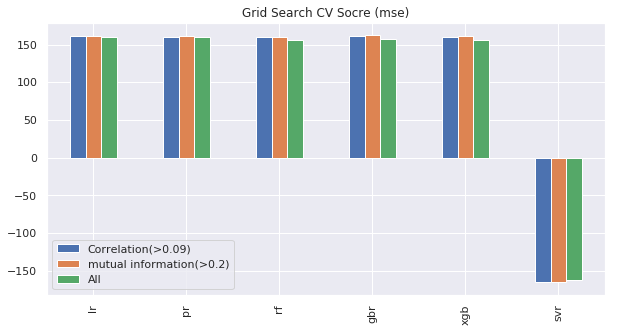

In [143]:
plot_result(results_mse_details,'Grid Search CV Socre (mse)')

In [144]:
results_r2_details={'Correlation(>0.09)':model_result_corr_r2,
                 'mutual information(>0.2)':model_result_mi_r2,
                 'All':model_result_all_r2}

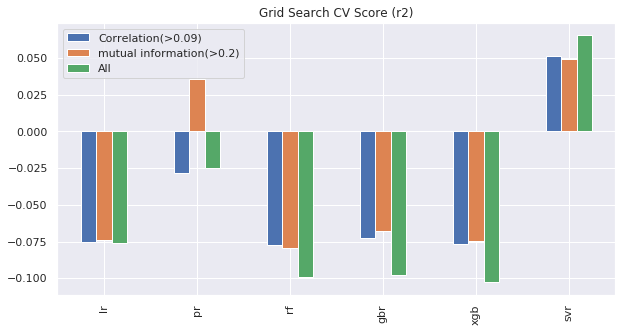

In [145]:
plot_result(results_r2_details,'Grid Search CV Score (r2)')
    

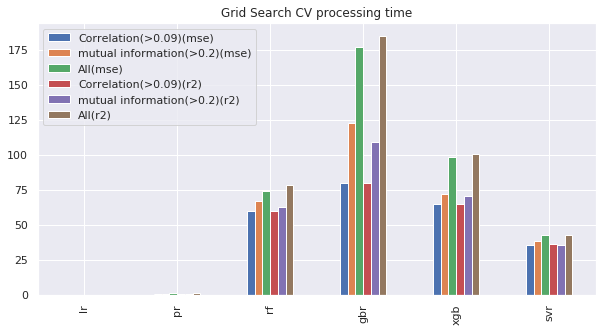

In [168]:

results_time=pd.DataFrame()
for x,y in {'mse':results_mse_time,'r2':results_r2_time}.items():
    for i,j in (y.items()):
        scores={k:v for (k,v) in j.items()}
        s=pd.Series(scores)
        results_time[i+'('+x+')']=s
        
results_time.plot(kind='bar',title='Grid Search CV processing time',figsize=(10,5))

In [79]:
X_test_all.shape

(772, 8)

In [80]:
y_test_all.shape

(772,)

In [113]:
def plot_degree_polynomial(X_train,y_train,X_test,y_test,s):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.metrics import mean_squared_error
    pr_cv_score=[]
    pr_test_score=[]
    #plot score per degree of polynomial
    for i in range(1,5):
        (model,cv_mse),_=build_pr(X_train,y_train,s,[i])
#         print(model,cv_mse)
        pr_cv_score.append(cv_mse)
        
        polynomial_features = PolynomialFeatures(degree=i)
        polynomial_features.fit(X_test)
        X_test_pr=polynomial_features.transform(X_test)

        prediction = model.predict(X_test_pr)
        test_mse=mean_squared_error(y_test,prediction)
#         _,test_mse=model_accuracy(model,X_test_pr,y)
        pr_test_score.append(test_mse)
        
    plt.figure(figsize=(5,5))
    plt.plot(range(1,5), pr_cv_score,label='training error')
    plt.plot(range(1,5), pr_test_score,label='testing error')
    plt.legend()
    plt.ylim(0, 400)
    plt.xlabel('polynomial degree')
    plt.ylabel('mse')
    plt.show()

build_lr- processing time: 00m 0s 095587ms
build_lr- processing time: 00m 0s 141422ms
build_lr- processing time: 00m 0s 267506ms
build_lr- processing time: 00m 1s 097270ms


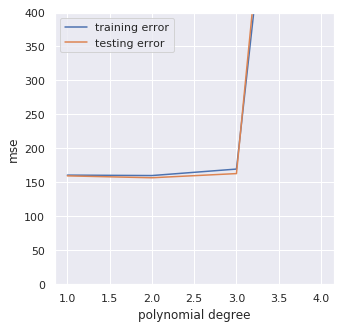

In [114]:
plot_degree_polynomial(X_train_all,y_train_all,X_test_all,y_test_all,'neg_mean_squared_error')

In [115]:
for i,j in (results_msr_details.items()):
    scores={k:v[1] for (k,v) in j.items()}
    s=pd.Series(scores)
    results_r2[i]=s

In [ ]:
#save model
model={}
model['lr']=model_result_all_msr['lr'][0]
model['pr']=model_result_all_msr['pr'][0]
model['rf']=model_result_all_msr['rf'][0]
model['gbr']=model_result_all_msr['gbr'][0]
model['xgb']=model_result_all_msr['xgb'][0]
#save training and testing data
with open('model.pickle','wb') as f:
    pickle.dump(model,f)

In [ ]:
#testing result

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
prediction={}
test_mse={}

for i,j in model_result_all_msr.items():
    print(i)
    y_predict=model_accuracy(j[0],X_test_all,y_test_all)
    prediction[i]=y_predict
    test_mse[i]=mean_squared_error(y_test_all,y_predict)

In [ ]:
#save GridSearchCV msr score and testing result for best models

In [ ]:
df_prediction=pd.DataFrame.from_dict(prediction)

In [ ]:
df_prediction['actual']=y_test_all.values

In [ ]:
# df_prediction['lr_diff']=abs(df_prediction.lr-df_prediction.actual)
# df_prediction['rf_diff']=abs(df_prediction.rf-df_prediction.actual)
# df_prediction['gbr_diff']=abs(df_prediction.gbr-df_prediction.actual)
# df_prediction['svr_diff']=abs(df_prediction.svr-df_prediction.actual)

In [ ]:
df_prediction.sort_values(by=['actual'],inplace=True)

In [ ]:
df_prediction.to_csv('df_prediction.csv',index=False)

In [ ]:
results_msr.index.name='model'

In [ ]:
results_msr.to_csv('df_result.csv',index=True,header=True)

In [ ]:
results_msr